In [1]:
import torchtext
torchtext.disable_torchtext_deprecation_warning()

import random
import nltk
import pickle
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt

In [2]:
max_length = 200
dimension = 100
glove = GloVe(name='6B', dim=dimension)
tokenizer = get_tokenizer('basic_english')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wctsai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def build_cross_similarity_cache(test_words, glove):
    similarity_dict = {}
    
    test_vectors = []
    for word in tqdm(test_words):
        vector = glove.vectors[glove.stoi[word]]
        test_vectors.append(vector.numpy())
    test_vectors = np.array(test_vectors)
    
    all_vectors = glove.vectors.numpy()
    all_words = list(glove.stoi.keys())
    
    batch_size = 256
    
    for i in tqdm(range(0, len(test_words), batch_size)):
        batch_vectors = test_vectors[i : i + batch_size]
        
        distances = cosine_distances(batch_vectors, all_vectors)
        
        for j, distances_for_word in enumerate(distances):
            word = test_words[i + j]
            
            most_similar_indexs = np.argsort(distances_for_word)[ : 1001]
            
            word_sim_pairs = [(all_words[index], float(distances_for_word[index])) for index in most_similar_indexs if all_words[index] != word][ : 1000]
            
            similarity_dict[word] = OrderedDict(word_sim_pairs)
    
    return similarity_dict

test_iter = IMDB(split='test')
test_glove_words = []

for label, line in test_iter:
    test_words = (tokenizer(line))
    for test_word in test_words:
        if test_word not in test_glove_words:
            if test_word in glove.stoi:
                test_glove_words.append(test_word)

glove_words = [word for word in glove.stoi]

similarity_cache = build_cross_similarity_cache(test_glove_words, glove)

with open('test_word_similarities_1000.pkl', 'wb') as f:
    pickle.dump(similarity_cache, f)

In [4]:
with open('test_word_similarities_1000.pkl', 'rb') as f:
    similarity_cache = pickle.load(f)

def find_similar_words(word, epsilon=0, size=1000):
    similar_words = list(similarity_cache[word].items())[ : size]
    # print(similar_words)
    if epsilon > 0:
        for index, ele in enumerate(similar_words):
            if ele[1] > epsilon:
                similar_words = similar_words[ : index]
    
    # print(word)
    if len(similar_words) > 0:
        if word == similar_words[0]:
            similar_words = similar_words[1 : ]
    
    return similar_words

In [5]:
# glove_words = []
# glove_vectors = []
# with open('glove.6B.100d.txt', 'r', encoding='utf8') as f:
#     for line in f:
#         values = line.split()
#         glove_words.append(values[0])
#         glove_vectors.append(np.asarray(values[1:], 'float32'))

# glove_vectors = np.array(glove_vectors)
# word_to_index = {word: idx for idx, word in enumerate(glove_words)}

# # nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(glove_vectors)
# nbrs = NearestNeighbors(n_neighbors=10, metric='cosine').fit(glove_vectors)

# def find_similar_words(word):
#     idx = word_to_index[word]
#     vector = glove_vectors[idx].reshape(1, -1)
#     distances, indices = nbrs.kneighbors(vector)
#     similar_words = [glove_words[i] for i in indices.flatten() if glove_words[i] != word]
#     return similar_words

In [6]:
# def find_similar_words(word, epsilon, maximum=50):
#     word_vector = glove[word]
#     similarities = {}

#     for candidate_word in glove.stoi:
#         if word == candidate_word or candidate_word.lower() in stop_words:
#             continue
        
#         candidate_vector = glove[candidate_word]
#         similarity = F.cosine_similarity(word_vector.unsqueeze(0), candidate_vector.unsqueeze(0))
        
#         # print(similarity)
#         if similarity > 1 - epsilon:
#             similarities[candidate_word] = similarity.item()
    
#     sorted_similar_words = sorted(similarities, key=similarities.get, reverse=True)[ : maximum]
#     return sorted_similar_words


# similarity_cache = {}
# def find_similar_words(word, epsilon, maximum=50):
#     if word in similarity_cache:
#         return similarity_cache[word]
#     word_vector = glove[word].unsqueeze(0)
#     candidate_vectors = torch.stack([glove[candidate_word] for candidate_word in glove.stoi if candidate_word.lower() not in stop_words])
    
#     similarities = F.cosine_similarity(word_vector, candidate_vectors, dim=1)
#     similar_indices = (similarities > 1 - epsilon).nonzero(as_tuple=True)[0]
    
#     sorted_indices = torch.argsort(similarities[similar_indices], descending=True)[:maximum]
#     similar_words = [list(glove.stoi.keys())[idx] for idx in sorted_indices]

#     if len(similar_words) > 0:
#         if similar_words[0] == word:
#             similar_words = similar_words[1 : ]
    
#     similarity_cache[word] = similar_words

#     return similar_words

In [7]:
class IMDBDataset(Dataset):
    def __init__(self, split, attack=None, epsilon=0, replace_num=200):
        self.data = list(IMDB(split=split))
        self.max_length = max_length
        self.attack = attack
        self.epsilon = epsilon
        self.replace_num = replace_num

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label, text = self.data[index]
        label = label - 1

        tokens = tokenizer(text)
        vectors = []

        tokens_length = len(tokens[ : self.max_length])
        selected_indexs = random.sample(range(tokens_length), tokens_length)
        for index, word in enumerate(tokens[ : self.max_length]):
            if word in glove.stoi:
                if not self.attack or (word.lower() in stop_words):
                    vectors.append(glove[word])
                    if index in selected_indexs[ : self.replace_num]:
                        selected_indexs.remove(index)
                else:
                    # if random.randint(1, 20) == 1:
                    if index in selected_indexs[ : self.replace_num]:
                        sorted_similar_words = find_similar_words(word, self.epsilon)
                        # sorted_similar_words = find_similar_words(word)
                        if len(sorted_similar_words) == 0:
                            sorted_similar_words = [word]
                        
                        if self.attack == 'random':
                            replacement = random.choice(sorted_similar_words)
                        elif self.attack == 'best':
                            replacement = sorted_similar_words[0]
                        elif self.attack == 'worst':
                            replacement = sorted_similar_words[-1]
                        vectors.append(glove[replacement])
                    else:
                        vectors.append(glove[word])
            else:
                vectors.append(torch.zeros(dimension))

        while len(vectors) < self.max_length:
            vectors.append(torch.zeros(dimension))
        
        return torch.stack(vectors).view(-1), label
        # return torch.stack(vectors), label

In [8]:
batch_size = 32
train_data = IMDBDataset(split='train')
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = IMDBDataset(split='test')
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

c:\Users\wctsa\Desktop\cs521\hw3\cs521\lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [9]:
# from torchtext.datasets import IMDB

# train_iter = IMDB(split='test')

# def tokenize(label, line):
#     return line.split()

# tokens = []
# length = []
# for label, line in train_iter:
#     length.append(len(line.split()))

# print(sum(length) / len(length))

In [10]:
class Net(nn.Module):
    def __init__(self, max_length, dimension):
        super(Net, self).__init__()
        dimension = max_length * dimension
        self.fc1 = nn.Linear(dimension, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [11]:
def bounds_calculation(model, data, epsilon):
    model.eval()
    lower_bound = data - epsilon
    upper_bound = data + epsilon

    # print(model.modules())
    layers = list(model.children())

    for layer in layers:
        # print(layer)
        if isinstance(layer, nn.ReLU):
            lower_bound = torch.clamp(lower_bound, min=0)
            upper_bound = torch.clamp(upper_bound, min=0)
            # https://github.com/google-deepmind/interval-bound-propagation/blob/217a14d12686e08ebb5cfea1f2748cce58a55913/interval_bound_propagation/src/crown.py


        elif isinstance(layer, nn.Linear):
            lower_bound = lower_bound.view(lower_bound.size(0), -1)
            upper_bound = upper_bound.view(upper_bound.size(0), -1)

            # print(layer.weight)

            positive = torch.clamp(layer.weight, min=0)
            negative = torch.clamp(layer.weight, max=0)

            lower = torch.matmul(lower_bound, positive.T) + torch.matmul(upper_bound, negative.T)
            upper = torch.matmul(upper_bound, positive.T) + torch.matmul(lower_bound, negative.T)

            lower_bound = lower + layer.bias
            upper_bound = upper + layer.bias

    return lower_bound, upper_bound

In [12]:
model = Net(max_length, dimension).to(device)
# model.load_state_dict(torch.load('model.pth'))
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def ibp_loss(normal_output, target, lower_bound, upper_bound, k):
    # https://github.com/google-deepmind/interval-bound-propagation/blob/217a14d12686e08ebb5cfea1f2748cce58a55913/interval_bound_propagation/src/loss.py
    normal_loss = criterion(normal_output, target)

    worst = lower_bound.clone()
    indexs = (torch.arange(target.size(0)), target)
    worst[indexs] = upper_bound[indexs]

    robust_loss = criterion(worst, target)

    return k * normal_loss + (1 - k) * robust_loss
    # return (1 - k) * normal_loss + k * robust_loss

In [14]:
def train(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        k = 1 - 0.5 * (epoch / epochs)
        e_train = 0.1 * (epoch / epochs)
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            lower_bound, upper_bound = bounds_calculation(model, data, e_train)

            # loss = criterion(outputs, target)
            loss = ibp_loss(output, target, lower_bound, upper_bound, k)

            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

In [15]:
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            predicted = torch.argmax(outputs, dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')
    return correct / total

In [16]:
epochs = 10

train(model, train_loader, optimizer, epochs)
test(model, test_loader)
# torch.save(model.state_dict(), 'model.pth')

Epoch [1/10], Loss: 0.7039
Epoch [2/10], Loss: 0.2978
Epoch [3/10], Loss: 0.2218
Epoch [4/10], Loss: 0.7102
Epoch [5/10], Loss: 0.2651
Epoch [6/10], Loss: 0.7952
Epoch [7/10], Loss: 0.0949
Epoch [8/10], Loss: 0.0367
Epoch [9/10], Loss: 0.0274
Epoch [10/10], Loss: 0.0016


100%|██████████| 782/782 [00:14<00:00, 54.12it/s]

Test Accuracy: 68.55%


0.68552

In [17]:
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
robust_accuracy = []

for epsilon in epsilons:
    attack_random_test_data = IMDBDataset(split='test', attack='random', epsilon=epsilon)
    attack_random_test_loader = DataLoader(attack_random_test_data, batch_size=batch_size, shuffle=False)
    robust_accuracy.append(test(model, attack_random_test_loader))

100%|██████████| 782/782 [04:00<00:00,  3.25it/s]


Test Accuracy: 67.46%


100%|██████████| 782/782 [04:30<00:00,  2.89it/s]


Test Accuracy: 65.45%


100%|██████████| 782/782 [06:25<00:00,  2.03it/s]


Test Accuracy: 57.78%


100%|██████████| 782/782 [10:08<00:00,  1.29it/s]


Test Accuracy: 55.93%


100%|██████████| 782/782 [08:59<00:00,  1.45it/s]


Test Accuracy: 55.87%


100%|██████████| 782/782 [05:45<00:00,  2.27it/s]


Test Accuracy: 55.86%


100%|██████████| 782/782 [03:11<00:00,  4.09it/s]


Test Accuracy: 55.86%


100%|██████████| 782/782 [03:05<00:00,  4.20it/s]


Test Accuracy: 55.86%


100%|██████████| 782/782 [03:19<00:00,  3.93it/s]


Test Accuracy: 55.86%


100%|██████████| 782/782 [03:15<00:00,  3.99it/s]

Test Accuracy: 55.86%


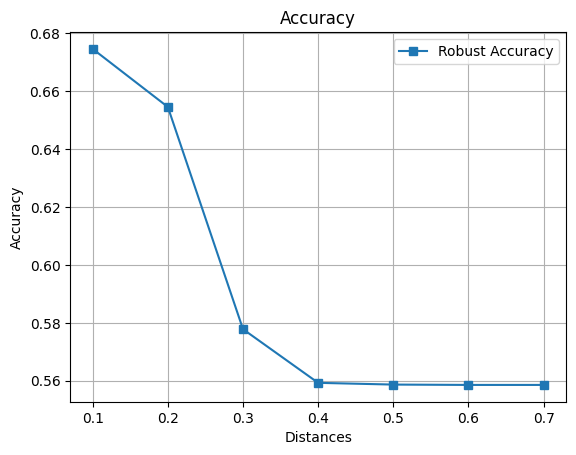

In [19]:
plt.plot(epsilons[ : 7], robust_accuracy[ : 7], marker='s', label='Robust Accuracy')

plt.xlabel('Distances')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.grid(True)
plt.show()